In [6]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import qutip as qt
from qutip import sigmax, sigmaz, sigmap, sigmam, tensor, identity

In [2]:
##### defining initial conditions/evolution operators

# Time and step variables
t_span = (0, 10)  # Time interval
t_eval = np.linspace(0, 10, 1000) 

#### Coefficients and Operators

# Coefficients
delta = 1
B = 0.5
gamma = 2

# Fundamental operators
s_p = np.array([[0,1], [0,0]]) # sigma plus operator
s_m = np.array([[0,0], [1,0]]) # sigma minus operator
s_z = np.array([[1,0], [0,-1]])# Pauli-Z operator
s_x = np.array([[0,1], [1,0]]) # Pauli-X operator
H = (1/np.sqrt(2))* np.array([[1,1], [1,-1]])  # Hadamard operator
I = np.array([[1,0],[0,1]]) # Identity



### Hamiltonian

#Hamiltonian = np.kron(np.kron(I,s_x),s_z)
# Hamiltonian matrix from Berislav Buˇca, Cameron Booker, and Dieter Jaksch
Hsum1 = np.kron(np.kron(s_p,s_m),I) + np.kron(np.kron(s_m,s_p),I) + delta * np.kron(np.kron(s_z,s_z),I) + B * np.kron(np.kron(I,s_z),I)
Hsum2 = np.kron(np.kron(s_m,I),s_p) + np.kron(np.kron(s_p,I),s_m) + delta * np.kron(np.kron(s_z,I),s_z) + B * np.kron(np.kron(s_z,I),I)
Hsum3 = np.kron(np.kron(I,s_p),s_m) + np.kron(np.kron(I,s_m),s_p) + delta * np.kron(np.kron(I,s_z),s_z) + B * np.kron(np.kron(I,I),s_z)

Hamiltonian = Hsum1 + Hsum2 + Hsum3
print("Hamiltonian matrix H: \n", Hamiltonian, "\n")

### V operator from Berislav Buˇca, Cameron Booker, and Dieter Jaksch

L = np.array([[0,0,0,0,0,0,0,0],[1,0,0,0,0,0,0,0],[-1,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0]])   # from paper
print("Lindblad Jump Operator V: \n", L, "\n")




#### initial state construction

# Basis vectors

state_vector0 = np.array([[1], [0]]) # ket |0>
state_vector_plus = H @ state_vector0 # ket |+> qubit in superposition state from 0

state_vector1 = np.array([[0], [1]]) # ket |1>
state_vector_minus = H @ state_vector1 # ket |-> qubit in superposition state from 1

# initial state vector

state_vector1plusplus = np.kron(state_vector0,np.kron(state_vector_plus,state_vector_plus)) # ket |0++>

# initial density matrix

"""rho0 = np.array(np.outer(state_vector1plusplus,state_vector1plusplus), dtype = 'complex') # initial state |0++>

# round rho0 to 2 decimal places to prevent roundoff error

rho0 = np.round(rho0,2)

if (np.trace(rho0) == 1.0):
    print("Initial state ρ(0): \n", rho0,"\n\n", "tr(rho0) = ", np.trace(rho0))
    
else:
    print(r"rho0 is not a valid quantum state: tr(rho0) ≠ 1.0")"""

rng = np.random.default_rng(4444)
rfloat = rng.random()
rho0 = np.empty((8,8))

for i in range(len(rho0)):
    for j in range(len(rho0)):
        rho0[i][j] = rng.random()

rho0 = rho0/np.trace(rho0) # off-diagonal elements != 0: Mixed state

"""Makes all elements except diagonal 0: Pure state

for i in range(len(rho0)):
    for j in range(len(rho0)):
        if i != j:
            rho0[i][j] = 0"""


print("Initial state of the system, rho0 is: \n",rho0)

Hamiltonian matrix H: 
 [[ 4.5  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -0.5  1.   0.   1.   0.   0.   0. ]
 [ 0.   1.  -0.5  0.   1.   0.   0.   0. ]
 [ 0.   0.   0.  -1.5  0.   1.   1.   0. ]
 [ 0.   1.   1.   0.  -0.5  0.   0.   0. ]
 [ 0.   0.   0.   1.   0.  -1.5  1.   0. ]
 [ 0.   0.   0.   1.   0.   1.  -1.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   1.5]] 

Lindblad Jump Operator V: 
 [[ 0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]] 

Initial state of the system, rho0 is: 
 [[0.03428678 0.33651956 0.26829466 0.11410343 0.18720029 0.30542251
  0.26562784 0.33466244]
 [0.26893925 0.23528    0.33022515 0.16319409 0.1404974  0.33467564
  0.18495638 0.17157208]
 [0.04784798 0.11763599 0.19646682 0.32671227 0.03987816 0.01317802
  0.26345926 0.28148649]
 [0.20855394 0.05628597 0.18881688 0.03409103 0.26020142 0.1377

In [3]:
# define Lindblad equation

def Lindblad(t, rho_flat, H, L, gamma):
    """
    Computes the Lindblad evolution for an open quantum system based on Hamiltonian 
    and single Lindblad operator L
    
    PARAMETERS:
        t           --  (float) The time at which the Lindblad evolution is calculated
        rho_flat    --  (numpy 1d array) flattened, vectorized form of initial state of rho
        H           --  (numpy 2d array) Hamiltonian, describes the determinstic evolution
        L           --  (numpy 2d array) Lindblad Jump operator, describes the non-deterministic 
                                        evolution from environmental noise

    RETURNS: (numpy 1d array))  The instantaneous rate of change of the quantum state 
                                over time as a differential: drho/dt
                                represented as a flattened 1d array from a 2d array (8,8 matrix)
    
    """

    rho = rho_flat.reshape((8, 8))
    
    V = L
    V_dag = V.conj().T
    
    drho_dt = -1j * (H @ rho - rho @ H) + gamma * (V @ rho @ V_dag - 0.5*(V_dag @ V @ rho) - 0.5*(rho @ V_dag @ V))
    
    return drho_dt.flatten()

# Define the evolution solver

def Lindblad_Evolution():

    H = Hamiltonian  # Constant Hamiltonian
    
    # Flatten the initial density matrix for the solver
    rho0_flat = rho0.flatten()
    
    # Solve the equation
    sol = solve_ivp(Lindblad, t_span, rho0_flat, args=(H, L, gamma), t_eval=t_eval, method='RK45')

    
    # Reshape the solution back into matrix form for each time point
    rho_t = np.array([sol.y[:, i].reshape((8, 8)) for i in range(len(sol.t))])
    return sol.t, rho_t



times, rho_t = Lindblad_Evolution()


/Users/advaithc/Jupyter Notebooks/Synchronization/lib/python3.9/site-packages/scipy/integrate/_ivp/base.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(fun(t, y), dtype=dtype)


In [12]:
# Qutip Lindblad equation
# find synchronizing and non-correleated stock data
# evaluaate model by extracting hamiltonian and jump operator at some time and testing the model at some initial time
# incorporate exponential growth, try inflation first, then fit to exponential and find r.

psi0 = qt.basis(2, 0)

Hsum1 = tensor(tensor(sigmap(), sigmam()),identity(2)) + tensor(tensor(sigmam(), sigmap()),identity(2)) + delta * tensor(tensor(sigmaz(),sigmaz()),identity(2)) + B * tensor(tensor(identity(2),sigmaz()),identity(2))
Hsum2 = tensor(tensor(sigmam(),identity(2)),sigmam()) + tensor(tensor(sigmam(),identity(2)),sigmam()) + delta * tensor(tensor(sigmam(),identity(2)),sigmam()) + B * tensor(tensor(sigmam(),identity(2)),identity(2))
Hsum3 = tensor(tensor(identity(2),sigmam()),sigmam()) + tensor(tensor(identity(2),sigmam()),sigmam()) + delta * tensor(tensor(identity(2),sigmam()),sigmam()) + B * tensor(tensor(identity(2),identity(2)),sigmam())

Hamiltonian = Hsum1 + Hsum2 + Hsum3


result = qt.mesolve(Hamiltonian, psi0, t_eval, [], [L])


fig, ax = subplots()

ax.plot(result.times, result.expect[0]);

ax.plot(result.times, result.expect[1]);

ax.set_xlabel('Time');

ax.set_ylabel('Expectation values');

ax.legend(("Sigma-Z", "Sigma-Y"));

show()


TypeError: incompatible dimensions [[2, 2, 2], [2, 2, 2]] and [[2], [1]]

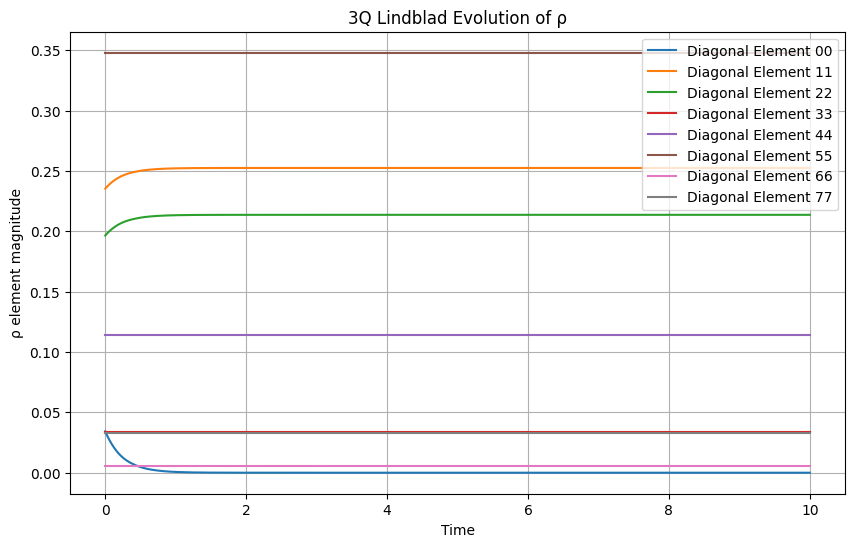

In [78]:
# Plot the evolution

def plot_8x8_Density(times,rho_t):
    
    # Plot the values of each element of rho against time
    plt.figure(figsize=(10, 6))
    
    """for i in range(8):
        for j in range(8):

            plt.plot(times, rho_t[:,i,j], label=f"Element {i}{j}")"""
    

    for i in range(8):
        plt.plot(times, rho_t[:,i,i], label=f"Diagonal Element {i}{i}")
    
    
    plt.xlabel('Time')
    plt.ylabel('ρ element magnitude')
    plt.title('3Q Lindblad Evolution of ρ')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return None

plot_8x8_Density(times,rho_t)

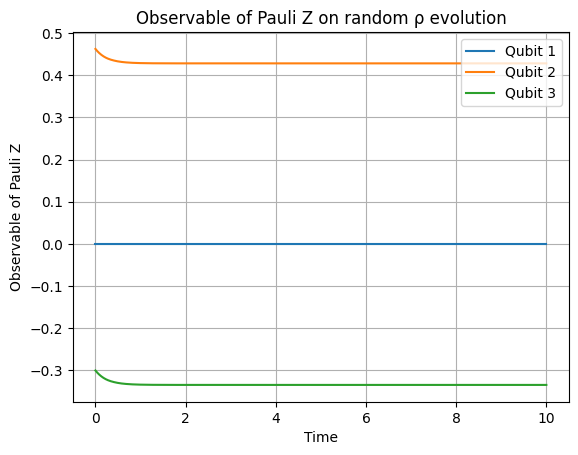

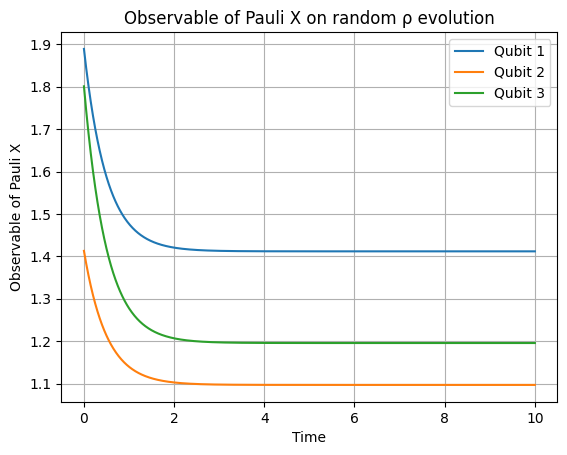

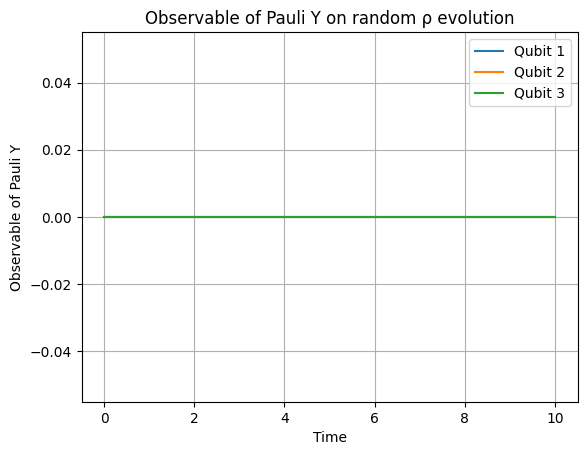

In [55]:
# Observable plotting

Lind_Evo = rho_t
t_list = times

# reshape lindblad evolution from (10001,64) to (10001,8,8)
Lind8x8 = Lind_Evo.reshape(len(t_list),8,8)


# Sigma x Pauli operator
sigx = np.array([[0,1], [1,0]])

# Pauli X on qubits 1,2,3
sigx1 = np.kron(np.kron(sigx,I),I)

sigx2 = np.kron(np.kron(I,sigx),I)

sigx3 = np.kron(np.kron(I,I),sigx)



# Sigma y Pauli operator
sigy = np.array([[0,-1j],[1j,0]])

# Pauli Y on qubits 1,2,3
sigy1 = np.kron(np.kron(sigy,I),I)

sigy2 = np.kron(np.kron(I,sigy),I)

sigy3 = np.kron(np.kron(I,I),sigy)


# Sigma Z Pauli operator
sigz = np.array([[1,0],[0,-1]])

# Pauli Z on qubits 1,2,3
sigz1 = np.kron(np.kron(sigz,I),I)

sigz2 = np.kron(np.kron(I,sigz),I)

sigz3 = np.kron(np.kron(I,I),sigz)


# Observable of Pauli X on qubits 1,2,3

obs_x1 = []
obs_x2 = []
obs_x3 = []

for i in range(len(Lind8x8)):
    obs_x1.append(np.trace(Lind8x8[i] @ sigx1)) #observing sigma x when applied to qubit 1
    obs_x2.append(np.trace(Lind8x8[i] @ sigx2))
    obs_x3.append(np.trace(Lind8x8[i]@ sigx3))
    
    
# Observable of Pauli Y on qubits 1,2,3

obs_y1 = []
obs_y2 = []
obs_y3 = []

for i in range(len(Lind8x8)):
    obs_y1.append(np.trace(Lind8x8[i] @ sigy1)) #observing sigma y when applied to qubit 1
    obs_y2.append(np.trace(Lind8x8[i] @ sigy2))
    obs_y3.append(np.trace(Lind8x8[i]@ sigy3))
    
    
# Observable of Pauli Z on qubits 1,2,3
obs_z1 = []
obs_z2 = []
obs_z3 = []

for i in range(len(Lind8x8)):
    obs_z1.append(np.trace(Lind8x8[i] @ sigz1)) #observing sigma z when applied to qubit 1
    obs_z2.append(np.trace(Lind8x8[i] @ sigz2))
    obs_z3.append(np.trace(Lind8x8[i]@ sigz3))

# Plot observable for all 3 qubits  
    
plt.plot(t_list,obs_z1,  label=f"Qubit 1")    
plt.plot(t_list,obs_z2,  label=f"Qubit 2")
plt.plot(t_list,obs_z3,  label=f"Qubit 3")


plt.xlabel('Time')
plt.ylabel('Observable of Pauli Z')
plt.title('Observable of Pauli Z on random ρ evolution')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
    
    
    

plt.plot(t_list,obs_x1,  label=f"Qubit 1")    
plt.plot(t_list,obs_x2,  label=f"Qubit 2")
plt.plot(t_list,obs_x3,  label=f"Qubit 3")

plt.xlabel('Time')
plt.ylabel('Observable of Pauli X')
plt.title('Observable of Pauli X on random ρ evolution')
plt.legend()
plt.grid(True)
plt.show()




plt.plot(t_list,obs_y1,  label=f"Qubit 1")    
plt.plot(t_list,obs_y2,  label=f"Qubit 2")
plt.plot(t_list,obs_y3,  label=f"Qubit 3")

plt.xlabel('Time')
plt.ylabel('Observable of Pauli Y')
plt.title('Observable of Pauli Y on random ρ evolution')
plt.legend()
plt.grid(True)
plt.show()

#print(Lind8x8[0],"\n",sigx3, "\n",  np.diag(sigx3 @ Lind8x8[0]))
